In [1]:
import os
import pandas as pd
import numpy as np
import sys

# additional paths
feature_path = os.path.join(os.getcwd(), '..', 'src', 'features')
visualize_path = os.path.join(os.getcwd(), '..', 'src', 'visualization')
sys.path.append(feature_path)
sys.path.append(visualize_path)


import build_features # type: ignore
import visualize # type: ignore
from sklearn.feature_selection import VarianceThreshold

In [2]:
path = os.path.join('..', 'data', 'interim', '01_H_Contortus_processed.pkl')
df = pd.read_pickle(path)
df.head()

,SMILES,ACTIVITY,ACTIVITY_SCORE,ACTIVATION_AT_6.8uM
PUBCHEM_RESULT_TAG,,,,
1,CC1=CC(=NC(=N1)NC2=NC(=CS2)C3=CC=CC=C3)C,1,100.0,36.85
2,CC1=C2C(=CC=C1)C(=C3C(=CC(=NC3=N2)C)C)N,1,84.0,31.28
3,CN1C2=CC=CC=C2N(C1=N)CC(=O)C3=CC=C(C=C3)Br.Br,1,77.0,28.61
4,C1=CC=C2C(=C1)C(=C3C=CC=CC3=N2)NCCCO,1,77.0,28.51
5,CC1=CC2=C(C=C1)N=C(N2)C3=C(C4=C(S3)N=C(C=C4)C)N,1,76.0,28.1


## Generating Mordred descriptors

Generating mordred from all smiles

In [3]:
smiles_list = df['SMILES'].to_list()
mordred_df = build_features.mordred_descriptors(smiles_list)
mordred_df.index = df.index
mordred_df['ACTIVITY'] = df['ACTIVITY']


empty_cols = mordred_df.columns[mordred_df.isna().sum() == 3416]
mordred_df.drop(columns=empty_cols, inplace=True)
mordred_df.head()

KeyboardInterrupt: 

## Loading Mordred descriptors dataset

In [4]:
path = os.path.join('..', 'data', 'interim', '02_H_Contortus_mordred_descriptors.pkl')

mordred_df = pd.read_pickle(path)
mordred_df.head()

,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,SpMAD_A,LogEE_A,VE1_A,VE2_A,...,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,ACTIVITY
PUBCHEM_RESULT_TAG,,,,,,,,,,,,,,,,,,,,,
1,0,0,25.802442,2.365976,4.651381,25.802442,1.290122,3.932435,4.097324,0.204866,...,66.954464,282.093917,8.296880,886,26,104.0,119.0,5.666667,4.361111,1
2,0,0,22.878917,2.509871,5.019743,22.878917,1.271051,3.847343,3.889241,0.216069,...,51.925327,237.126597,7.185654,532,33,100.0,122.0,6.388889,3.833333,1
3,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,70.666210,422.958186,11.431302,2100000928,34,112.0,134.0,NaN,4.583333,1
4,0,0,25.434668,2.474546,4.949092,25.434668,1.338667,3.881497,3.768225,0.198328,...,52.493641,252.126263,7.203608,674,30,98.0,116.0,4.805556,4.361111,1
5,0,0,27.566121,2.512375,4.789613,27.566121,1.312672,4.018370,4.162911,0.198234,...,71.719636,294.093917,8.402683,904,34,120.0,146.0,6.250000,4.388889,1


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

new_df = mordred_df # shuffle(mordred_df)

# splitting into train and test data
X = new_df.loc[:, mordred_df.columns != 'ACTIVITY']
y = new_df['ACTIVITY']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.3, shuffle=True)


print('Total train samples: ', y_train.count())
print('Total test samples: ', y_test.count())

Total train samples:  2391
Total test samples:  1025


## Initial predictions

In [16]:
# pipeline with Imputation

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


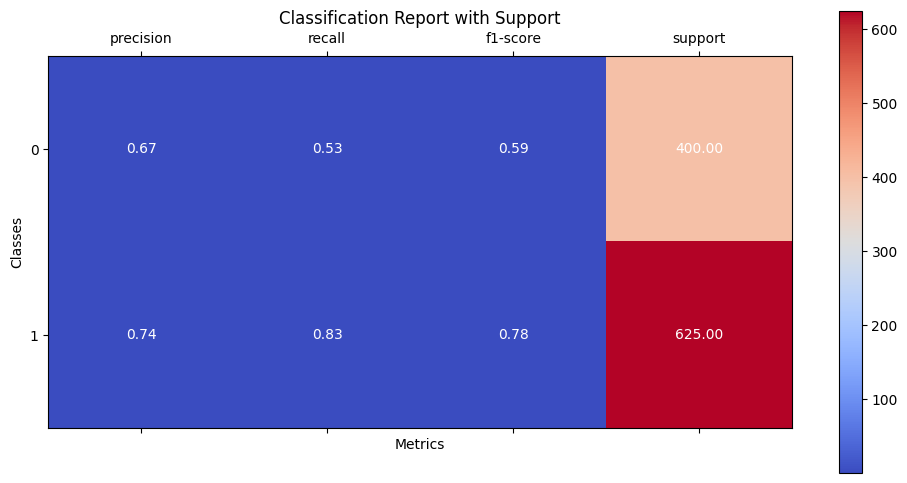

In [17]:
from sklearn.ensemble import RandomForestClassifier

rfc_pipe = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer()),('svc', RandomForestClassifier())]).fit(X_train, y_train)
rfc_pred = rfc_pipe.predict(X_test)

visualize.plot_classification_report(y_test, rfc_pred)

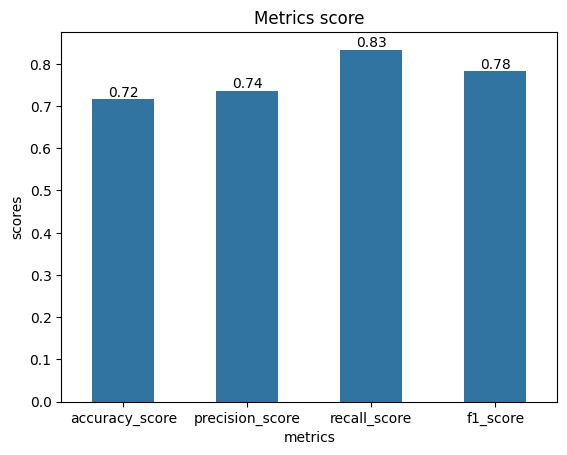

In [18]:
visualize.plot_scores(y_test, rfc_pred )


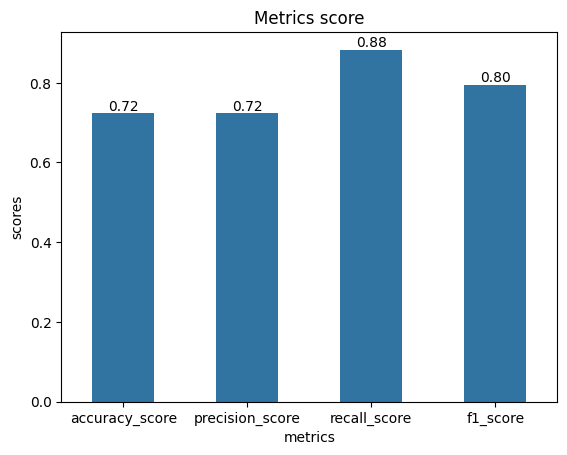

In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

pipe = Pipeline([('scaler', StandardScaler()), ('imputer', SimpleImputer()),('svc', SVC())]).fit(X_train, y_train)
y_pred = pipe.predict(X_test)

visualize.plot_scores(y_test, y_pred)

## Pre processing

Removal of highly correlated features

Text(0.5, 1.0, 'Correlation of first 20 descriptors')

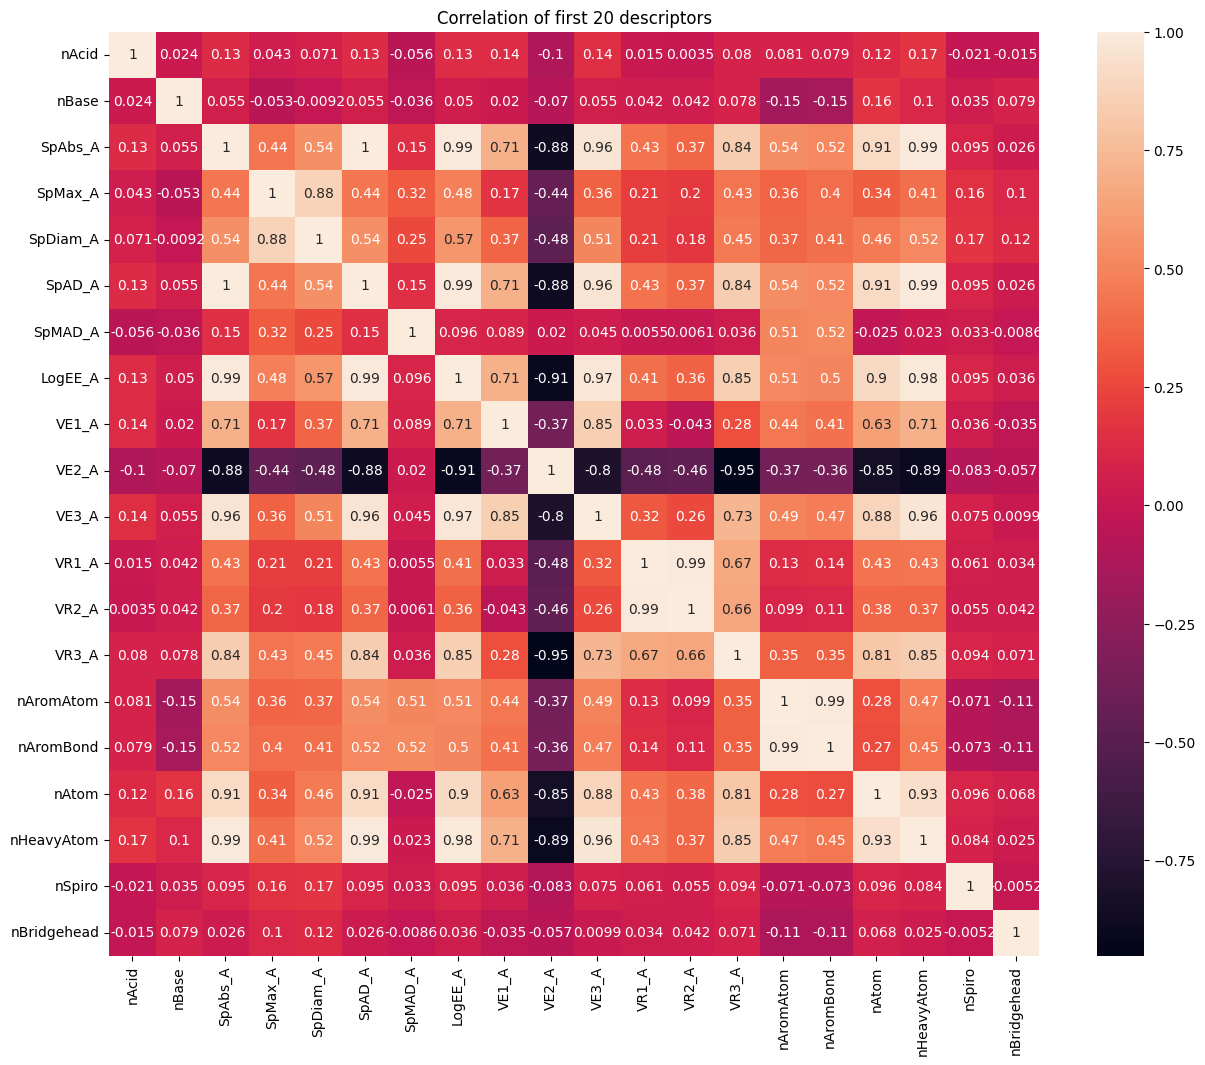

In [25]:
import matplotlib.pyplot as plt

correlation_df = X_train.corr(method='pearson')
idx = correlation_df.index[:20]

import seaborn as sns

plt.figure(figsize=(15, 12))
sns.heatmap(correlation_df.loc[idx, idx], annot=True)
plt.title('Correlation of first 20 descriptors')

<Axes: xlabel='VR2_A', ylabel='VE2_A'>

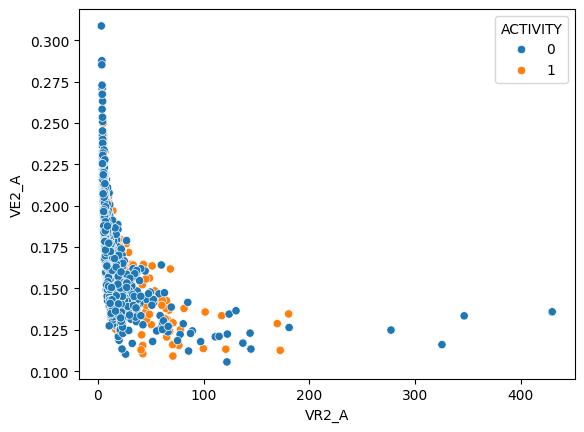

In [26]:
sns.scatterplot(data=mordred_df, x='VR2_A',y='VE2_A', hue='ACTIVITY')

In [27]:
def get_collinears(dataset, threshold):
    collinear_cols = set()
    corr = dataset.corr()
    for i in range(len(corr.columns)):
        for j in range(i):
            if abs(corr.iloc[i,j]) > threshold:
                colname = corr.columns[i]
                collinear_cols.add(colname)
    
    return list(collinear_cols)

collinear_columns = get_collinears(X_train, 0.85)    
print('nuber of collinear columns: ', len(collinear_columns))

nuber of collinear columns:  984


In [28]:
non_collinear_df = X_train.drop(collinear_columns, axis = 1)
non_collinear_df.head()

,nAcid,nBase,SpAbs_A,SpMax_A,SpMAD_A,VE1_A,VR1_A,nAromAtom,nSpiro,nBridgehead,...,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TSRW10
PUBCHEM_RESULT_TAG,,,,,,,,,,,,,,,,,,,,,
2277,0,2,NaN,NaN,NaN,NaN,NaN,9,0,0,...,0.074074,0.043478,0.046550,0.017372,0.019909,0.019457,0.010332,0.012346,0.000000,63.979675
2292,0,0,37.319117,2.379192,1.286866,4.465124,280.319010,16,0,0,...,0.089947,0.055217,0.036374,0.023852,0.018906,0.011574,0.009898,0.007500,0.005929,79.621719
1942,0,0,39.133735,2.524919,1.304458,4.072275,3046.290238,12,0,0,...,0.075650,0.053005,0.053794,0.022616,0.023216,0.014084,0.010782,0.008607,0.006273,79.016302
1213,0,0,27.626884,2.349668,1.315566,3.828220,193.499505,12,0,0,...,0.071685,0.029167,0.046138,0.022059,0.011327,0.010091,0.011779,0.007125,0.007559,54.689062
1848,0,2,30.169568,2.399502,1.311720,3.865108,277.334237,16,0,0,...,0.084967,0.044643,0.037926,0.020566,0.017184,0.013455,0.008434,0.005625,0.005597,57.218157


### grouping columns

In [29]:
# fig, axes = plt.subplots(3, 2)

# columns = non_collinear_df.columns
# col_idxs = [6, 1, 14, 3, 100, 50]

# axes[0, 0].hist(non_collinear_df[columns[col_idxs[0]]])
# axes[0, 0].set_title(columns[col_idxs[0]])

# axes[0, 1].hist(non_collinear_df[columns[col_idxs[1]]])
# axes[0, 1].set_title(columns[col_idxs[1]])

# axes[1, 0].hist(non_collinear_df[columns[col_idxs[2]]])
# axes[1, 0].set_title(columns[col_idxs[2]])

# axes[1, 1].hist(non_collinear_df[columns[col_idxs[3]]])
# axes[1, 1].set_title(columns[col_idxs[3]])

# axes[2, 0].hist(non_collinear_df[columns[col_idxs[4]]])
# axes[2, 0].set_title(columns[col_idxs[4]])

# axes[2, 1].hist(non_collinear_df[columns[col_idxs[5]]])
# axes[2, 1].set_title(columns[col_idxs[5]])


# fig.set_figwidth(15)
# fig.set_figheight(8)
# fig.tight_layout()

Classifying columns into discrete, categorical or continuous

In [30]:
non_collinear_df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('bool')], dtype=object)

columns with data type of int64 are more likely to be discrete columns or encoded categorical columns. Columns with dtype float64 are continuous columns whereas columns with bool dtypes are categorical columsn

In [31]:
continuous_cols = non_collinear_df.dtypes[non_collinear_df.dtypes == 'float64'].index
discrete_cols = non_collinear_df.dtypes[non_collinear_df.dtypes == 'int64'].index
categorical_cols = non_collinear_df.dtypes[non_collinear_df.dtypes == 'bool'].index

discrete_cols = discrete_cols[VarianceThreshold(threshold=0.01).fit(non_collinear_df[discrete_cols]).get_support()] # get high variance discrete cols

print('number of discrete columns: ', len(discrete_cols))
print('number of continuous columns: ', len(continuous_cols))

number of discrete columns:  64
number of continuous columns:  289


Removing data features that have number of missing values greater than a defined percentage threshold

In [32]:
# removing percentage of missing continuous values
missing_percentage = 0.8

row_length = non_collinear_df.shape[0]
missing_length_threshold = round(row_length * missing_percentage, 0)
print("missing values greater than: ",missing_length_threshold)

continuous_cols = non_collinear_df[continuous_cols].isna().sum()[non_collinear_df[continuous_cols].isna().sum() < missing_length_threshold].index

missing values greater than:  1913.0


In [33]:
print(len(continuous_cols))

286


Outlier removal with standardization method

In [34]:
non_collinear_standardized_df = pd.DataFrame(StandardScaler().fit_transform(non_collinear_df[continuous_cols]))
non_collinear_standardized_df = pd.DataFrame(SimpleImputer().fit_transform(non_collinear_standardized_df))
non_collinear_standardized_df.columns = non_collinear_df[continuous_cols].columns

# update continuous cols after scaling
continuous_cols = continuous_cols[VarianceThreshold(threshold=0.01).fit(non_collinear_standardized_df[continuous_cols]).get_support()] # get high variance discrete cols
non_collinear_standardized_df = non_collinear_standardized_df[continuous_cols]

non_collinear_standardized_df.index = non_collinear_df[continuous_cols].index
non_collinear_standardized_df.head()

,SpAbs_A,SpMax_A,SpMAD_A,VE1_A,VR1_A,ATS0Z,AATS0dv,AATS7dv,AATS0d,AATS6d,...,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TSRW10
PUBCHEM_RESULT_TAG,,,,,,,,,,,,,,,,,,,,,
2277,-2.610032e-16,-4.083932e-16,1.555272e-15,5.688334e-16,-3.070625e-18,0.739645,-0.816950,0.247843,-1.427756,-1.900140,...,-0.097464,-0.253080,0.771599,-1.410341,0.761038,1.925501,0.245337,1.290924,-1.642162,-0.274876
2292,1.477189e+00,-5.263100e-01,-4.758459e-01,1.481196e+00,-8.082228e-03,1.321024,0.121470,-0.178384,-0.502563,-0.732953,...,1.157043,0.697766,-0.434270,-0.279083,0.509849,-0.292182,0.120891,-0.060545,0.006039,1.499522
1942,1.783374e+00,1.408570e+00,1.263376e-02,2.838424e-01,4.974368e+00,0.920073,0.280527,0.647596,0.256425,0.089787,...,0.027097,0.518568,1.630143,-0.494852,1.588898,0.413982,0.374768,0.248027,0.101557,1.430845
1213,-1.582018e-01,-9.183059e-01,3.210783e-01,-4.600041e-01,-1.644735e-01,-0.082304,-0.410243,-0.076164,-0.399175,-0.033306,...,-0.286315,-1.412349,0.722757,-0.592163,-1.387920,-0.709347,0.660885,-0.165222,0.459017,-1.328783
1848,2.708307e-01,-2.566374e-01,2.142959e-01,-3.475743e-01,-1.345881e-02,-0.533374,-0.192112,0.463019,-0.330406,-0.698054,...,0.763472,-0.158746,-0.250387,-0.852712,0.078595,0.236905,-0.299446,-0.583601,-0.086283,-1.041888


In [35]:
non_collinear_standardized_df.shape

(2391, 284)

In [36]:
# applying df outliers
def filter_outliers(row):
    max_std = row.max()
    min_std = row.min()
    mean_std = row.mean()
    std_std = row.std()
    
    if max_std > 7 or min_std < -7:
        return False
    
    if (max_std <= 3 and abs(min_std) < 3):
        # not an outlier
        return True
        
    s_new = mean_std + 1.28 * std_std
    
    if s_new <= 3:
        #not an outlier
        return True
    
    return False


# mask based on outliers
outlier_mask = non_collinear_standardized_df.apply(filter_outliers, axis=1)
keep_index = outlier_mask[outlier_mask == True].index
len(keep_index)

2259

## final df

In [37]:
total_columns = list(discrete_cols) + list(continuous_cols) # concat columns
# keep_index

final_df1 = (non_collinear_df.loc[keep_index])[total_columns]

In [165]:
# figure = plt.figure(figsize=(5,5))
# p = sns.displot(data=final_df1, x='nX', stat='percent', hue=y.loc[keep_index], height=3, weights=6)
# plt.show()

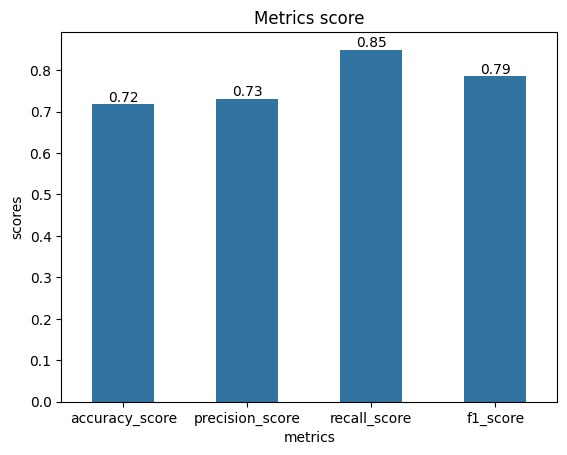

In [210]:
final_rfc1 = RandomForestClassifier(n_estimators=700).fit(final_df1, y_train.loc[keep_index])
final_pred = final_rfc1.predict(X_test[total_columns])
visualize.plot_scores(y_test, final_pred)

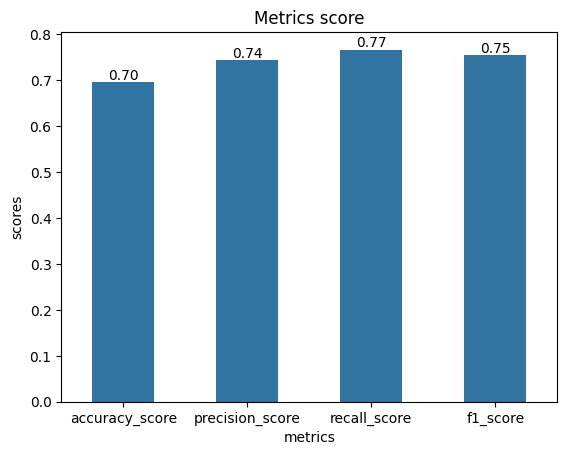

In [209]:
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

svc_pipeline = Pipeline([('impute', SimpleImputer()),('scale', StandardScaler()), ('smote', SMOTE()), ('prev', SVC())]).fit(final_df1, y_train.loc[keep_index])
finalsvc_pred = svc_pipeline.predict(X_test[total_columns])
visualize.plot_scores(y_test, finalsvc_pred)

In [49]:
import pickle

keep_columns = final_df1.columns.to_numpy()

with open('columns.pkl', 'wb') as f:
    pickle.dump(keep_columns, f)

In [40]:
# from sklearn.compose import ColumnTransformer

# ct = ColumnTransformer(
#     [('sel_fill_missing',SimpleImputer(), total_columns)]
# )

# rf_pipeline = Pipeline([('impute', ct),('scale', StandardScaler()), ('smote', SMOTE()), ('prev', SVC())]).fit(final_df1, y_train.loc[keep_index])

,0,1,2,3,4,5,6,7,8,9,...,338,339,340,341,342,343,344,345,346,347
0,0.0,2.0,9.0,0.0,8.0,4.0,1.0,2.0,0.0,1.0,...,0.074074,0.043478,0.046550,0.017372,0.019909,0.019457,0.010332,0.012346,0.000000,63.979675
1,0.0,0.0,16.0,0.0,11.0,6.0,3.0,2.0,0.0,0.0,...,0.089947,0.055217,0.036374,0.023852,0.018906,0.011574,0.009898,0.007500,0.005929,79.621719
2,0.0,0.0,12.0,0.0,7.0,1.0,5.0,0.0,0.0,1.0,...,0.075650,0.053005,0.053794,0.022616,0.023216,0.014084,0.010782,0.008607,0.006273,79.016302
3,0.0,0.0,12.0,0.0,5.0,2.0,2.0,0.0,0.0,1.0,...,0.071685,0.029167,0.046138,0.022059,0.011327,0.010091,0.011779,0.007125,0.007559,54.689062
4,0.0,2.0,16.0,0.0,4.0,2.0,2.0,0.0,0.0,0.0,...,0.084967,0.044643,0.037926,0.020566,0.017184,0.013455,0.008434,0.005625,0.005597,57.218157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2386,0.0,1.0,18.0,0.0,10.0,4.0,3.0,2.0,0.0,1.0,...,0.075556,0.045777,0.035840,0.023295,0.018033,0.011748,0.009181,0.008774,0.006395,85.077220
2387,0.0,0.0,17.0,0.0,5.0,3.0,1.0,0.0,0.0,1.0,...,0.074074,0.037500,0.024924,0.029938,0.015699,0.005787,0.005316,0.007625,0.000000,64.604946
2388,0.0,0.0,11.0,0.0,5.0,3.0,1.0,1.0,0.0,0.0,...,0.071429,0.063333,0.029111,0.023164,0.016188,0.013025,0.011087,0.008542,0.012346,67.112228
2389,0.0,0.0,15.0,0.0,8.0,4.0,2.0,0.0,1.0,1.0,...,0.085470,0.054119,0.041577,0.025450,0.022653,0.012663,0.011316,0.009833,0.008214,81.886221


## Grid Search for Random Forest classifier

In [168]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {
    'n_estimators': [100, 300, 500, 700, 1000, 1500],
    'criterion': ['gini', 'entropy', 'log_loss']
}


grid_rfc = GridSearchCV(RandomForestClassifier(), param_grid, refit=True, verbose=3, cv=2)
grid_rfc.fit(final_df1, y_train.loc[keep_index])

Fitting 2 folds for each of 18 candidates, totalling 36 fits
[CV 1/2] END ..criterion=gini, n_estimators=100;, score=0.681 total time=   2.2s
[CV 2/2] END ..criterion=gini, n_estimators=100;, score=0.700 total time=   2.0s
[CV 1/2] END ..criterion=gini, n_estimators=300;, score=0.681 total time=   5.3s
[CV 2/2] END ..criterion=gini, n_estimators=300;, score=0.712 total time=   6.3s
[CV 1/2] END ..criterion=gini, n_estimators=500;, score=0.680 total time=  10.2s
[CV 2/2] END ..criterion=gini, n_estimators=500;, score=0.706 total time=  10.1s
[CV 1/2] END ..criterion=gini, n_estimators=700;, score=0.686 total time=  13.0s
[CV 2/2] END ..criterion=gini, n_estimators=700;, score=0.711 total time=  13.9s
[CV 1/2] END .criterion=gini, n_estimators=1000;, score=0.688 total time=  19.5s
[CV 2/2] END .criterion=gini, n_estimators=1000;, score=0.716 total time=  20.3s
[CV 1/2] END .criterion=gini, n_estimators=1500;, score=0.687 total time=  28.7s
[CV 2/2] END .criterion=gini, n_estimators=1500;

GridSearchCV(cv=2, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [100, 300, 500, 700, 1000, 1500]},
             verbose=3)

## Applicability domain with standardiazation

In [303]:
train_mean = final_df1.mean()
train_std = final_df1.std()

In [305]:
train_mean

nAcid           0.074812
nBase           0.146968
nAromAtom      14.354139
nBridgehead     0.011510
nHetero         5.332891
                 ...    
JGI7            0.012564
JGI8            0.009412
JGI9            0.007670
JGI10           0.005884
TSRW10         66.093625
Length: 348, dtype: float64

In [309]:
ad_df = ((X_test[total_columns] - train_mean) / train_std)

In [316]:
ad_df.shape

(1025, 348)

In [321]:
ad_mask = ad_df.apply(filter_outliers, axis=1)
X_test.loc[ad_mask, total_columns]

d:\Users\Gabriel Anyaele\Desktop\daf12-antihelminthic-drugdiscovery\venv\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


,nAcid,nBase,nAromAtom,nBridgehead,nHetero,nN,nO,nS,nF,nCl,...,JGI2,JGI3,JGI4,JGI5,JGI6,JGI7,JGI8,JGI9,JGI10,TSRW10
PUBCHEM_RESULT_TAG,,,,,,,,,,,,,,,,,,,,,
812,0,0,12,0,5,3,0,0,1,1,...,0.077295,0.045455,0.032778,0.015046,0.023673,0.009425,0.006173,0.008958,0.000000,49.103575
2513,0,0,10,0,6,2,3,0,0,0,...,0.094017,0.056878,0.045556,0.023889,0.017493,0.014759,0.010417,0.007500,0.014132,66.016495
2275,0,0,11,0,7,3,3,1,0,0,...,0.085470,0.072917,0.045231,0.033521,0.026572,0.018818,0.015573,0.006989,0.006173,75.244170
1476,0,0,18,0,7,2,4,0,0,1,...,0.082126,0.040365,0.044134,0.026809,0.016443,0.014111,0.010997,0.007250,0.007660,67.575185
654,0,0,12,0,6,2,3,0,1,0,...,0.091954,0.050000,0.037094,0.024306,0.019112,0.014275,0.006859,0.007232,0.007009,54.297472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147,0,0,12,0,3,1,2,0,0,0,...,0.064516,0.034274,0.047111,0.023990,0.014286,0.011863,0.006299,0.007708,0.005663,54.733938
2919,0,0,14,0,8,5,3,0,0,0,...,0.072072,0.077381,0.039910,0.021159,0.024187,0.009384,0.011844,0.008889,0.008118,74.627836
2471,0,0,11,0,5,3,1,1,0,0,...,0.088889,0.041035,0.037485,0.024965,0.017839,0.011409,0.007266,0.006406,0.006173,63.491453


In [323]:
ad_pred = final_rfc1.predict(X_test.loc[ad_mask, total_columns])

In [327]:
y_pred[ad_mask].shape

(899,)

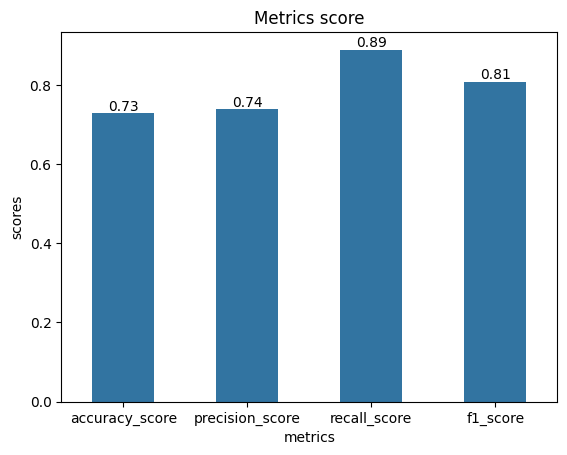

In [329]:
visualize.plot_scores(y_test[ad_mask], ad_pred)

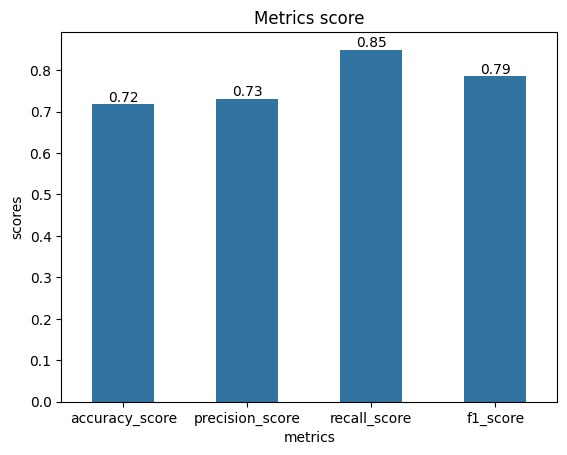

In [335]:
visualize.plot_scores(y_test, final_pred)

In [341]:
# import pickle
# pickle_path = os.path.join('..', 'models', 'rfc_model.pkl')
# pickle.dump(final_rfc1, open(pickle_path, 'wb'))